In [6]:
import os

root_directory = os.path.join(os.getcwd(), "Water Bodies Dataset")  # Get the full path
print("Dataset path:", root_directory)

if os.path.exists(root_directory):
    print("Dataset directory found!")
else:
    print("Dataset directory NOT found!")

Dataset path: /Users/srinivasadesikan/PRJ12&4/Water Bodies Dataset
Dataset directory found!


In [53]:
import os
import numpy as np
from tqdm import tqdm
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout


In [8]:
import os

base_path = "/Users/srinivasadesikan/PRJ12&4/Water Bodies Dataset"
image_path = os.path.join(base_path, "Images/")
mask_path = os.path.join(base_path, "Masks/")

if os.path.exists(image_path):
    print(f"Image path found: {image_path}")
else:
    print("Image path not found.")

if os.path.exists(mask_path):
    print(f"Mask path found: {mask_path}")
else:
    print("Mask path not found.")


Image path found: /Users/srinivasadesikan/PRJ12&4/Water Bodies Dataset/Images/
Mask path found: /Users/srinivasadesikan/PRJ12&4/Water Bodies Dataset/Masks/


In [9]:
print(os.path.exists(mask_path))
print(os.listdir(mask_path) if os.path.exists(mask_path) else "Path not found")


True
['water_body_8448.jpg', 'water_body_2171.jpg', 'water_body_1478.jpg', 'water_body_1336.jpg', 'water_body_8474.jpg', 'water_body_8312.jpg', 'water_body_1450.jpg', 'water_body_7035.jpg', 'water_body_1444.jpg', 'water_body_8460.jpg', 'water_body_7753.jpg', 'water_body_7960.jpg', 'water_body_7948.jpg', 'water_body_2367.jpg', 'water_body_7579.jpg', 'water_body_1108.jpg', 'water_body_8892.jpg', 'water_body_2415.jpg', 'water_body_8138.jpg', 'water_body_2373.jpg', 'water_body_1652.jpg', 'water_body_7223.jpg', 'water_body_8110.jpg', 'water_body_7545.jpg', 'water_body_8676.jpg', 'water_body_1134.jpg', 'water_body_7551.jpg', 'water_body_8662.jpg', 'water_body_1120.jpg', 'water_body_2429.jpg', 'water_body_1646.jpg', 'water_body_7237.jpg', 'water_body_775.jpg', 'water_body_8851.jpg', 'water_body_8689.jpg', 'water_body_8845.jpg', 'water_body_2398.jpg', 'water_body_1849.jpg', 'water_body_1691.jpg', 'water_body_7586.jpg', 'water_body_7592.jpg', 'water_body_1685.jpg', 'water_body_985.jpg', 'water_

In [10]:
image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])


In [13]:
images = np.zeros(shape=(len(image_names), SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names), SIZE, SIZE, 1))


In [40]:
SIZE = 128 

In [14]:
for id in tqdm(range(len(image_names)), desc="Images"):
    path = image_path + image_names[id]
    img = np.asarray(Image.open(path)).astype('float') / 255.  
    img = cv.resize(img, (SIZE, SIZE), cv.INTER_AREA)
    images[id] = img


Images: 100%|██████████| 2841/2841 [00:10<00:00, 266.01it/s]


In [15]:
for id in tqdm(range(len(mask_names)), desc="Mask"):
    path = mask_path + mask_names[id]
    mask = np.asarray(Image.open(path)).astype('float') / 255.
    mask = cv.resize(mask, (SIZE, SIZE), cv.INTER_AREA)
    masks[id] = mask[:, :, :1]


Mask: 100%|██████████| 2841/2841 [00:10<00:00, 277.61it/s] 


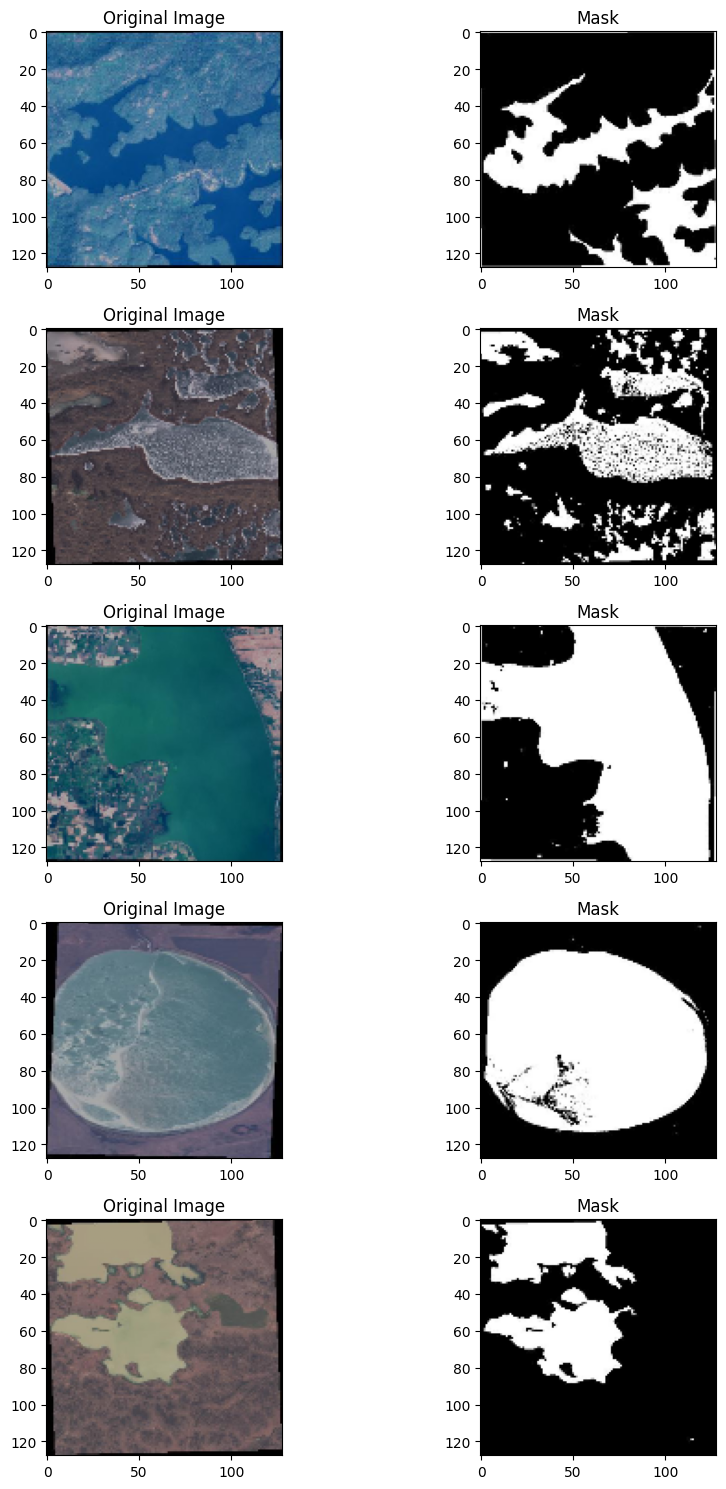

In [22]:
plt.figure(figsize=(10,15))
for i in range(1,11):
  plt.subplot(5,2,i)

  if i%2!=0:
    id = np.random.randint(len(images))
    plt.imshow(images[id], cmap=None)
    plt.title('Original Image')
  elif i%2==0:
    plt.imshow(masks[id].reshape(128,128), cmap='gray')
    plt.title('Mask')

plt.tight_layout()
plt.show()

In [17]:
images_train, images_test, mask_train, mask_test = train_test_split(images, masks, test_size=0.25)

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, 
                                     Dropout, BatchNormalization, Activation, Add, GlobalAveragePooling2D, 
                                     Dense, Reshape, Multiply)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Squeeze-and-Excitation (SE) Block
def se_block(inputs, reduction=16):
    filters = inputs.shape[-1]
    se = GlobalAveragePooling2D()(inputs)
    se = Dense(filters // reduction, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([inputs, se])

# Residual Block with SE Block
def residual_block(inputs, filters):
    shortcut = Conv2D(filters, (1, 1), padding="same")(inputs)
    
    x = Conv2D(filters, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-5))(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.2)(x)  # Reduced Dropout

    x = Conv2D(filters, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = BatchNormalization()(x)
    x = se_block(x)  # SE Block
    x = Add()([x, shortcut])  # Residual connection
    x = Activation("relu")(x)
    
    return x

# U-Net++ Model with SE Blocks
def unet_plus_plus(input_shape=(128, 128, 3), start_neurons=16):
    inputs = Input(input_shape)

    # Encoder
    conv1_1 = residual_block(inputs, start_neurons)
    pool1 = MaxPooling2D((2, 2))(conv1_1)

    conv2_1 = residual_block(pool1, start_neurons * 2)
    pool2 = MaxPooling2D((2, 2))(conv2_1)

    conv3_1 = residual_block(pool2, start_neurons * 4)
    pool3 = MaxPooling2D((2, 2))(conv3_1)

    conv4_1 = residual_block(pool3, start_neurons * 8)
    pool4 = MaxPooling2D((2, 2))(conv4_1)

    # Bottleneck
    conv5_1 = residual_block(pool4, start_neurons * 16)

    # Decoder
    up4_2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(conv5_1)
    merge4_2 = concatenate([up4_2, conv4_1])
    conv4_2 = residual_block(merge4_2, start_neurons * 8)

    up3_2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(conv4_2)
    merge3_2 = concatenate([up3_2, conv3_1])
    conv3_2 = residual_block(merge3_2, start_neurons * 4)

    up2_2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(conv3_2)
    merge2_2 = concatenate([up2_2, conv2_1])
    conv2_2 = residual_block(merge2_2, start_neurons * 2)

    up1_2 = Conv2DTranspose(start_neurons, (3, 3), strides=(2, 2), padding="same")(conv2_2)
    merge1_2 = concatenate([up1_2, conv1_1])
    conv1_2 = residual_block(merge1_2, start_neurons)

    # Output Layer
    output_layer = Conv2D(1, (1, 1), activation="sigmoid")(conv1_2)

    model = Model(inputs, output_layer)
    return model

In [34]:
model = unet_plus_plus()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", iou_metric])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 128, 128,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ activation_18[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 128, 128,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 1)         │         17 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 16)        │         32 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 1, 1, 16)  │          0 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Multiply)          │ 16)               │            │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 128, 128,  │         64 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 128, 128,  │          0 │ multiply_9[0][0], │
│                     │ 16)               │            │ conv2d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 128, 128,  │          0 │ add_9[0][0]       │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ activation_19[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_32[0][0] 

 Total params: 2,266,831 (8.65 MB)

 Trainable params: 2,263,887 (8.64 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [35]:
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Thresholding
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + tf.keras.backend.epsilon()) 

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, min_lr=1e-6)

In [38]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Define callback to display accuracy
class ShowMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}: Accuracy = {logs['accuracy']:.4f}, Val Accuracy = {logs['val_accuracy']:.4f}")

# Train the model
epochs = 50
batch_size = 32

history = model.fit(
    images_train, mask_train,
    validation_data=(images_test, mask_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[ShowMetrics()]
)


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.7129 - loss: 0.3298Epoch 1: Accuracy = 0.7207, Val Accuracy = 0.6808
67/67 ━━━━━━━━━━━━━━━━━━━━ 61s 840ms/step - accuracy: 0.7130 - loss: 0.3296 - val_accuracy: 0.6808 - val_loss: 0.3786
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.7308 - loss: 0.2897Epoch 2: Accuracy = 0.7283, Val Accuracy = 0.7011
67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 841ms/step - accuracy: 0.7308 - loss: 0.2898 - val_accuracy: 0.7011 - val_loss: 0.3270
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.7379 - loss: 0.2853Epoch 3: Accuracy = 0.7328, Val Accuracy = 0.6842
67/67 ━━━━━━━━━━━━━━━━━━━━ 57s 852ms/step - accuracy: 0.7378 - loss: 0.2853 - val_accuracy: 0.6842 - val_loss: 0.3897
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.7339 - loss: 0.2853Epoch 4: Accuracy = 0.7350, Val Accuracy = 0.7065
67/67 ━━━━━━━━━━━━━━━━━━━━ 57s 845ms/step - accuracy: 0.7340 - loss: 0.2852 - val_accuracy: 0.7065 - val_l

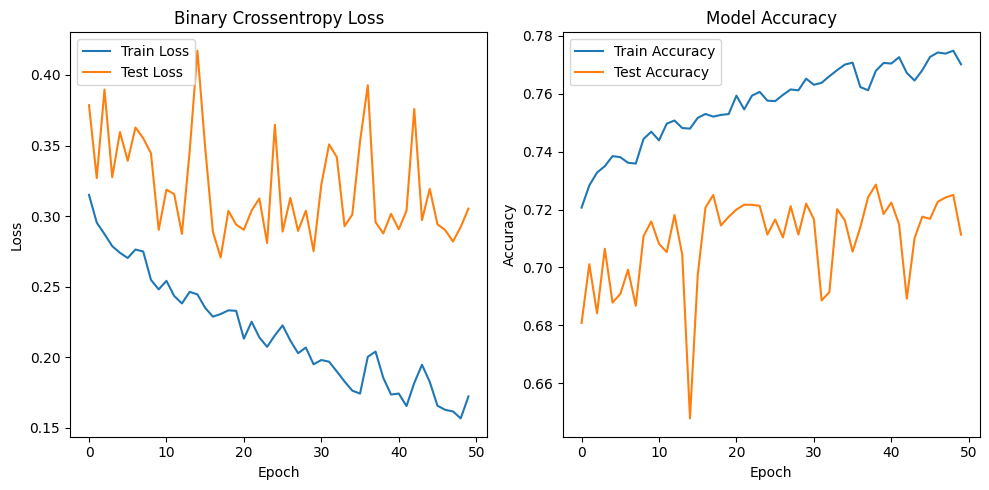

In [39]:
plt.figure(figsize=(10, 5))

# Plot loss for each epoch
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history.get('val_loss', []), label="Test Loss")
plt.title('Binary Crossentropy Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot accuracy for each epoch
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history.get('val_accuracy', history.history.get('val_acc', [])), label="Test Accuracy")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


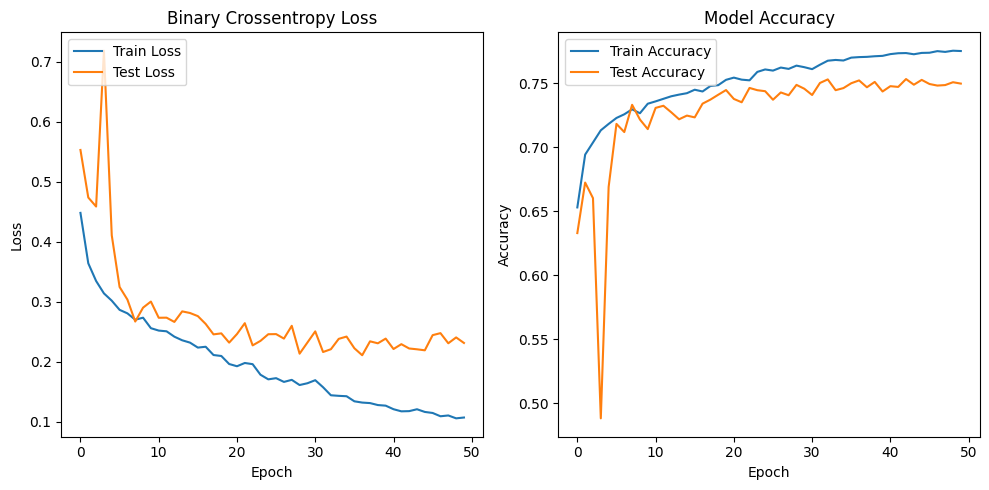

In [58]:
plt.figure(figsize=(10, 5))

# Plot loss for each epoch
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history.get('val_loss', []), label="Test Loss")
plt.title('Binary Crossentropy Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot accuracy for each epoch
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history.get('val_accuracy', history.history.get('val_acc', [])), label="Test Accuracy")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [59]:
predictions = model.predict(images_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step


In [ ]:
model.save("unet_plus_plus_se_model.h5") 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


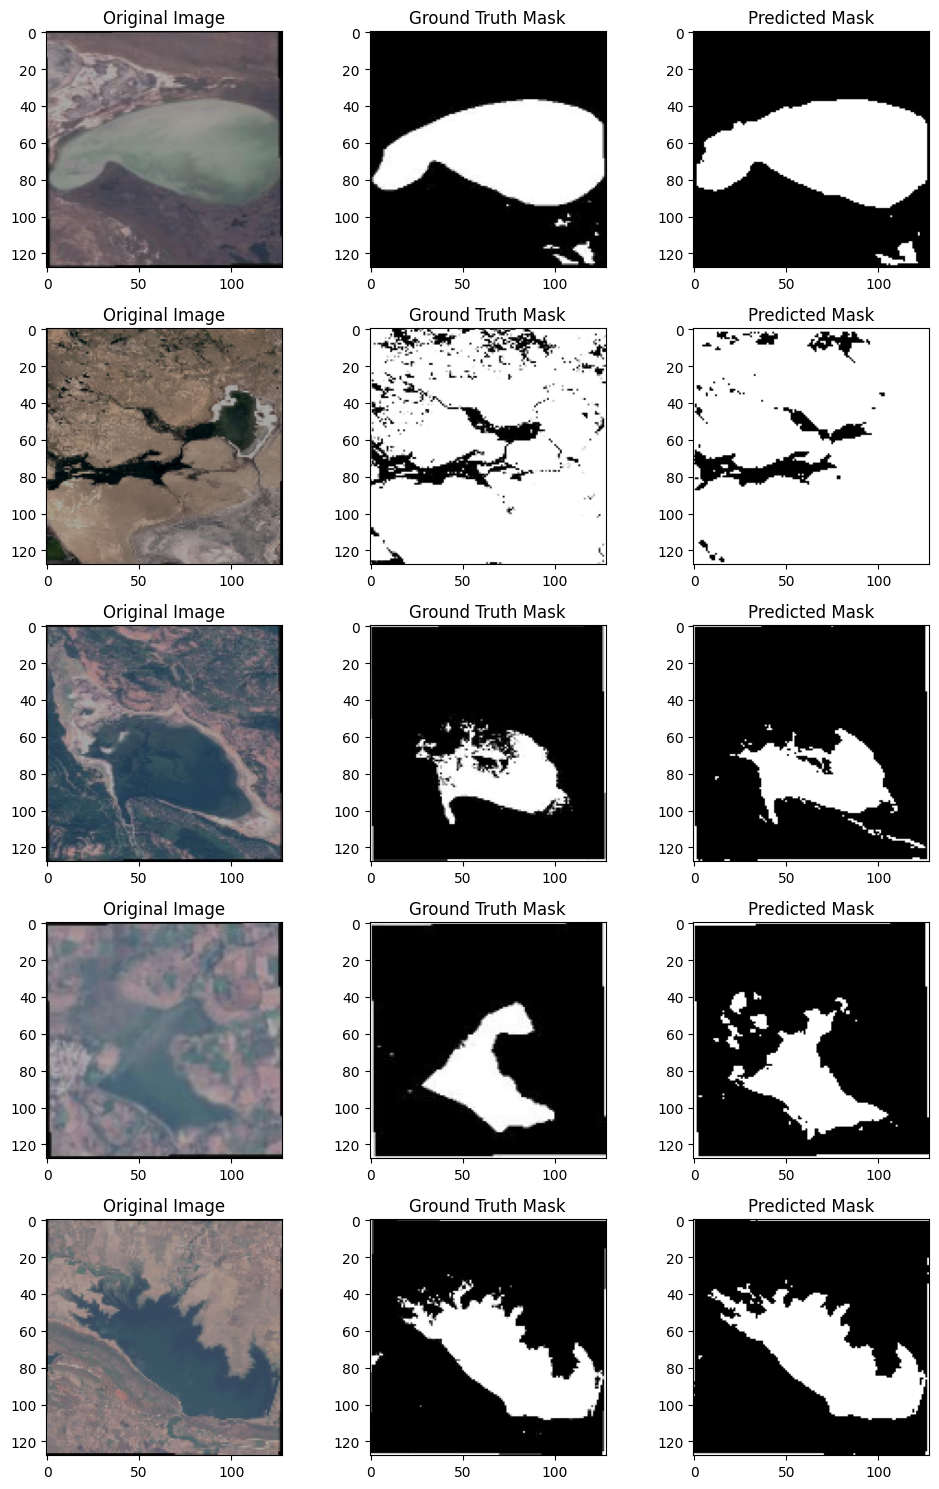

In [75]:
plt.figure(figsize=(10, 15))
for i in range(1, 16):  # Now looping for 15 images (original, ground truth, predicted)
    plt.subplot(5, 3, i)

    if i % 3 == 1:  # Original Image
        id = np.random.randint(len(images))
        plt.imshow(images[id], cmap=None)
        plt.title('Original Image')

    elif i % 3 == 2:  # Ground Truth Mask
        plt.imshow(masks[id].reshape(128, 128), cmap='gray')
        plt.title('Ground Truth Mask')

    else:  # Predicted Mask
        img = np.expand_dims(images[id], axis=0)  # Prepare for model input
        predicted_mask = model.predict(img)[0]
        predicted_mask = (predicted_mask > 0.3).astype(np.uint8)
        plt.imshow(predicted_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


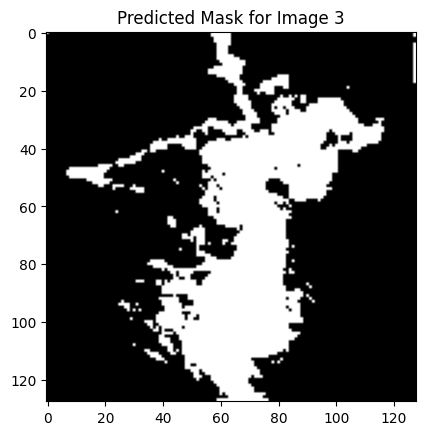

In [19]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Dataset paths
base_path = "/Users/srinivasadesikan/PRJ12&4/Water Bodies Dataset"
image_path = os.path.join(base_path, "Images/")

# Verify path
if not os.path.exists(image_path):
    print("Image path not found.")
    exit()

# Load images
image_filenames = sorted(os.listdir(image_path))

# Load model
model = load_model("unet_plus_plus_se_model.h5")

# Output directory
output_dir = "predicted_masks"
os.makedirs(output_dir, exist_ok=True)

# Function to predict mask for a given image number
def predict_mask(image_number):
    filename = f"water_body_{image_number}.jpg"
    if filename not in image_filenames:
        print("Image number not found!")
        return

    idx = image_filenames.index(filename)
    img = cv2.imread(os.path.join(image_path, filename))
    img = cv2.resize(img, (128, 128)) / 255.0
    img = np.expand_dims(img, axis=0)

    predicted_mask = model.predict(img)[0]
    predicted_mask = (predicted_mask > 0.4).astype(np.uint8)

    # Save predicted mask
    mask_filename = f"unet_mask_{image_number}.png"
    cv2.imwrite(os.path.join(output_dir, mask_filename), predicted_mask * 255)

    # Show the predicted mask
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title(f'Predicted Mask for Image {image_number}')
    plt.show()

# Predict for image 855
predict_mask(3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


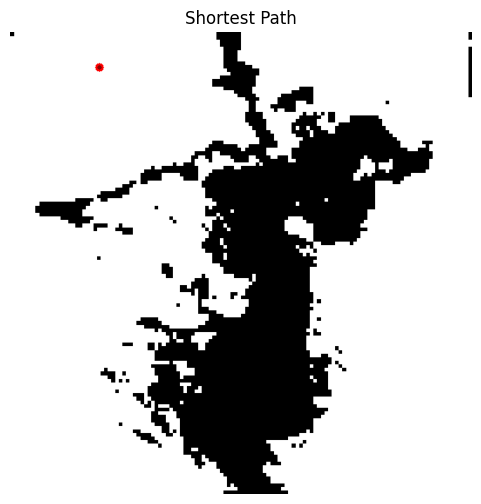

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappop, heappush
from tensorflow.keras.models import load_model

# Dataset paths
base_path = "/Users/srinivasadesikan/PRJ12&4/Water Bodies Dataset"
image_path = os.path.join(base_path, "Images/")

# Verify path
if not os.path.exists(image_path):
    print("Image path not found.")
    exit()

# Load the trained U-Net model
model = load_model("unet_plus_plus_se_model.h5")

# Output directories
output_dir = "predicted_masks"
os.makedirs(output_dir, exist_ok=True)
output_grid_dir = "output_images"
os.makedirs(output_grid_dir, exist_ok=True)

def predict_mask(image_number):
    """Predicts the water body mask for a given image number using the U-Net model."""
    filename = f"water_body_{image_number}.jpg"
    if filename not in os.listdir(image_path):
        print("Image number not found!")
        return

    img = cv2.imread(os.path.join(image_path, filename))
    img_resized = cv2.resize(img, (128, 128)) / 255.0
    img_resized = np.expand_dims(img_resized, axis=0)

    # Generate predicted mask
    predicted_mask = model.predict(img_resized)[0]
    predicted_mask = (predicted_mask > 0.4).astype(np.uint8)  # Apply threshold

    # Resize mask back to original size
    original_size = (img.shape[1], img.shape[0])
    predicted_mask = cv2.resize(predicted_mask, original_size, interpolation=cv2.INTER_NEAREST)

    # **Invert the mask**: Ensure **water is white (255), land is black (0)**
    predicted_mask = 255 - (predicted_mask * 255)

    # Save the predicted mask
    mask_filename = f"unet_mask_{image_number}.png"
    mask_path = os.path.join(output_dir, mask_filename)
    cv2.imwrite(mask_path, predicted_mask)

    # Process the predicted mask to mark the shortest path
    output_path = os.path.join(output_grid_dir, f"path_on_unet_{image_number}.png")
    mark_grid_and_path(mask_path, output_path, start_point=(127, 50))

def mark_grid_and_path(mask_path, output_path, start_point=(127, 50), grid_size=10):
    """Overlays the shortest path on the predicted U-Net mask."""
    # Load U-Net predicted mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Convert to RGB for visualization
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    # Mark the start point
    sx, sy = start_point
    cv2.circle(mask_rgb, (sx, sy), 6, (255, 0, 0), -1)  # Mark start point in red

    # Dijkstra's Algorithm Setup
    height, width = mask.shape
    visited = set()
    distances = {start_point: 0}
    priority_queue = []
    heappush(priority_queue, (0, sx, sy, []))  # (distance, x, y, path)

    directions = [
        (-1, 0), (1, 0), (0, -1), (0, 1),  # Up, down, left, right
        (-1, -1), (-1, 1), (1, -1), (1, 1)  # Diagonals
    ]

    river_paths = []

    while priority_queue:
        current_distance, cx, cy, path = heappop(priority_queue)

        if (cx, cy) in visited:
            continue
        visited.add((cx, cy))

        if mask[cy, cx] == 255:  # Water region detected (since we inverted mask)
            river_paths.append(path + [(cx, cy)])
            continue

        for dx, dy in directions:
            nx, ny = cx + dx * grid_size, cy + dy * grid_size
            if 0 <= nx < width and 0 <= ny < height and (nx, ny) not in visited:
                new_distance = current_distance + (np.sqrt(2) if (dx != 0 and dy != 0) else 1)

                if (nx, ny) not in distances or new_distance < distances[(nx, ny)]:
                    distances[(nx, ny)] = new_distance
                    heappush(priority_queue, (new_distance, nx, ny, path + [(cx, cy)]))

    # Draw shortest path
    if river_paths:
        shortest_path = river_paths[0]
        for (px, py) in shortest_path:
            cv2.circle(mask_rgb, (px, py), 3, (139, 0, 0), -1)
            if shortest_path.index((px, py)) > 0:
                prev_px, prev_py = shortest_path[shortest_path.index((px, py)) - 1]
                cv2.line(mask_rgb, (prev_px, prev_py), (px, py), (139, 0, 0), 2)

    # Save and display
    cv2.imwrite(output_path, mask_rgb)
    plt.figure(figsize=(6, 6))
    plt.imshow(mask_rgb)
    plt.axis('off')
    plt.title("Shortest Path")
    plt.show()  

# Run the pipeline for an example image
predict_mask(3)


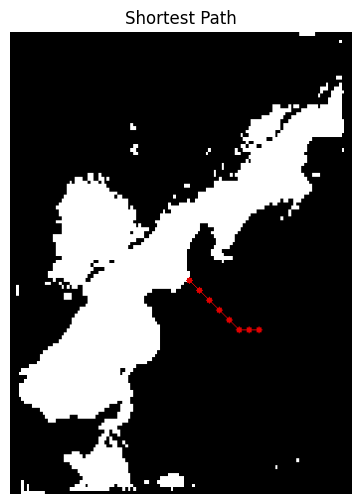

In [191]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappop, heappush

def mark_grid_and_path(mask_path, start_point=(250, 300), grid_size=10):
    """Overlays the shortest path on the predicted U-Net mask without saving the image."""
    # Load U-Net predicted mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Convert to RGB for visualization
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    # Mark the start point
    sx, sy = start_point
    cv2.circle(mask_rgb, (sx, sy), 1, (255, 0, 0), -1)  # Mark start point in red

    # Dijkstra's Algorithm Setup
    height, width = mask.shape
    visited = set()
    distances = {start_point: 0}
    priority_queue = []
    heappush(priority_queue, (0, sx, sy, []))  # (distance, x, y, path)

    directions = [
        (-1, 0), (1, 0), (0, -1), (0, 1),  # Up, down, left, right
        (-1, -1), (-1, 1), (1, -1), (1, 1)  # Diagonals
    ]

    river_paths = []

    while priority_queue:
        current_distance, cx, cy, path = heappop(priority_queue)

        if (cx, cy) in visited:
            continue
        visited.add((cx, cy))

        if mask[cy, cx] == 255:  # Water region detected (since we inverted mask)
            river_paths.append(path + [(cx, cy)])
            continue

        for dx, dy in directions:
            nx, ny = cx + dx * grid_size, cy + dy * grid_size
            if 0 <= nx < width and 0 <= ny < height and (nx, ny) not in visited:
                new_distance = current_distance + (np.sqrt(2) if (dx != 0 and dy != 0) else 1)

                if (nx, ny) not in distances or new_distance < distances[(nx, ny)]:
                    distances[(nx, ny)] = new_distance
                    heappush(priority_queue, (new_distance, nx, ny, path + [(cx, cy)]))

    # Draw shortest path
    if river_paths:
        shortest_path = river_paths[0]
        for (px, py) in shortest_path:
            cv2.circle(mask_rgb, (px, py), 3, (225, 0, 0), -1) 
            if shortest_path.index((px, py)) > 0:
                prev_px, prev_py = shortest_path[shortest_path.index((px, py)) - 1]
                cv2.line(mask_rgb, (prev_px, prev_py), (px, py), (225, 0, 0), 1)  # Thinner line


    # Display the image without saving
    plt.figure(figsize=(6, 6))
    plt.imshow(mask_rgb)
    plt.axis('off')
    plt.title("Shortest Path")
    plt.show()

# Provide the path to your mask image
mask_image_path = "predicted_masks/unet_mask_1417.png"
mark_grid_and_path(mask_image_path)


In [ ]:
CAN I USE? NOW yes